In [23]:
import os
import ast
import pandas as pd
import tensorflow as tf
import keras
import keras_cv
from keras_cv import bounding_box, visualization

In [8]:
os.getcwd()

'/home/jackson/DamageAI/SDC/reproducible_example'

In [5]:
!git clone https://github.com/jacky-ct/SampleData

Cloning into 'SampleData'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (102/102), 26.13 MiB | 1.01 MiB/s, done.


In [26]:
IMAGE_PATH = "./SampleData/"
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [10]:
data = pd.read_csv(f"{IMAGE_PATH}sample.csv")

classes = [i.strip() for i in set(data["class"])]
class_mapping = dict(zip(classes, range(len(classes))))

In [11]:
def get_data(data):
    img_paths = []
    classes = []
    boxes = []
    for image in set(data["image"]):
        img_classes = []
        img_boxes = []

        for instance in data[data["image"] == image].iterrows():
            img_classes.append(class_mapping[instance[1]["class"]])
            img_boxes.append(ast.literal_eval(instance[1]["coords"]))

        img_paths.append(f"{IMAGE_PATH}{image}.jpg")
        classes.append(img_classes)
        boxes.append(img_boxes)

    return (img_paths, classes, boxes)


In [15]:
print([len(i) for i in get_data(data)])
labels = get_data(data)

bools = []
for i, j in enumerate(labels[1]):
    bools.append(len(j) == len(labels[2][i]))

print(f"len = {len(bools)}, set = {set(bools)}")

[99, 99, 99]
len = 99, set = {True}


In [17]:
image_paths = tf.ragged.constant(labels[0])
classes = tf.ragged.constant(labels[1])
bbox = tf.ragged.constant(labels[2])

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [18]:
train_data = data.take(90)
val_data = data.skip(90)

In [19]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [24]:
augmentor = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="rel_xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="rel_xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="rel_xyxy"
        ),
    ]
)

In [32]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# if you comment out the below line and rerun the cell then the bounding boxes work
train_ds = train_ds.map(augmentor, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="rel_xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

{'classes': <tf.RaggedTensor [[0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0], [0.0]]>, 'boxes': <tf.RaggedTensor [[[0.6629399, 0.9548458, 0.6829179, 0.904185],
  [0.59109235, 0.5517621, 0.60227275, 0.5446035],
  [0.60795456, 0.6368392, 0.6193182, 0.6261013]] ,
 [[0.57239735, 0.33204845, 0.58284456, 0.3276432],
  [0.5958578, 0.594163, 0.62921554, 0.46117842]]  ,
 [[0.60575515, 0.5187225, 0.6178519, 0.5121145],
  [0.6317815, 0.6729075, 0.6446114, 0.6665749],
  [0.5692815, 0.30451542, 0.5813783, 0.29900882]],
 [[0.63159823, 0.3276432, 0.6427786, 0.3243392]]]>}
{'classes': <tf.RaggedTensor [[], [], [], []]>, 'boxes': <tf.RaggedTensor [[], [], [], []]>}


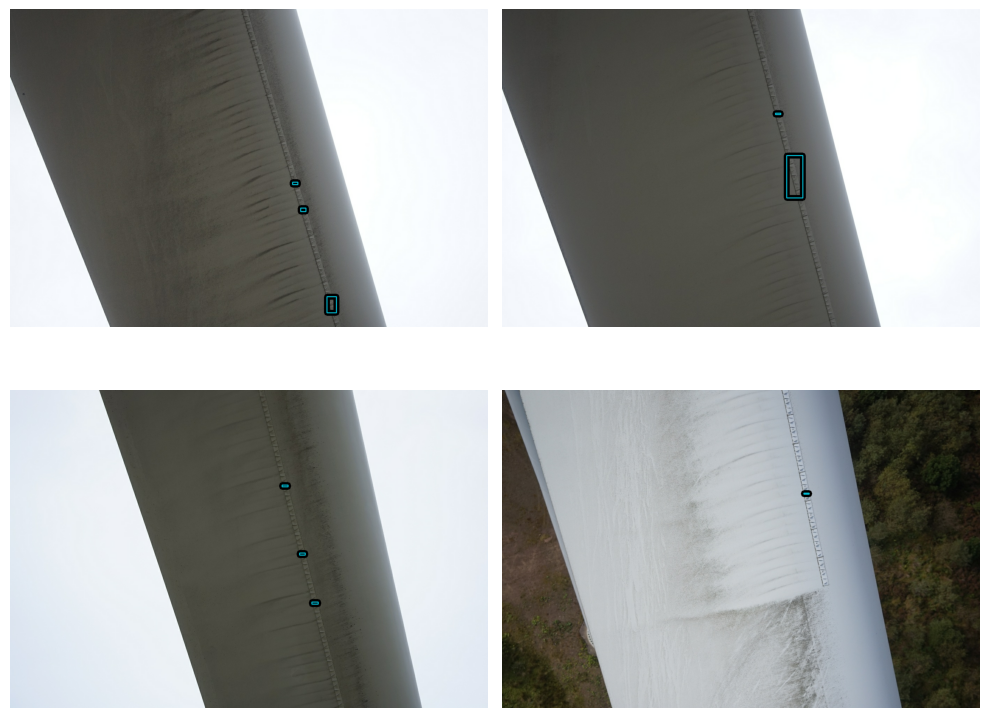

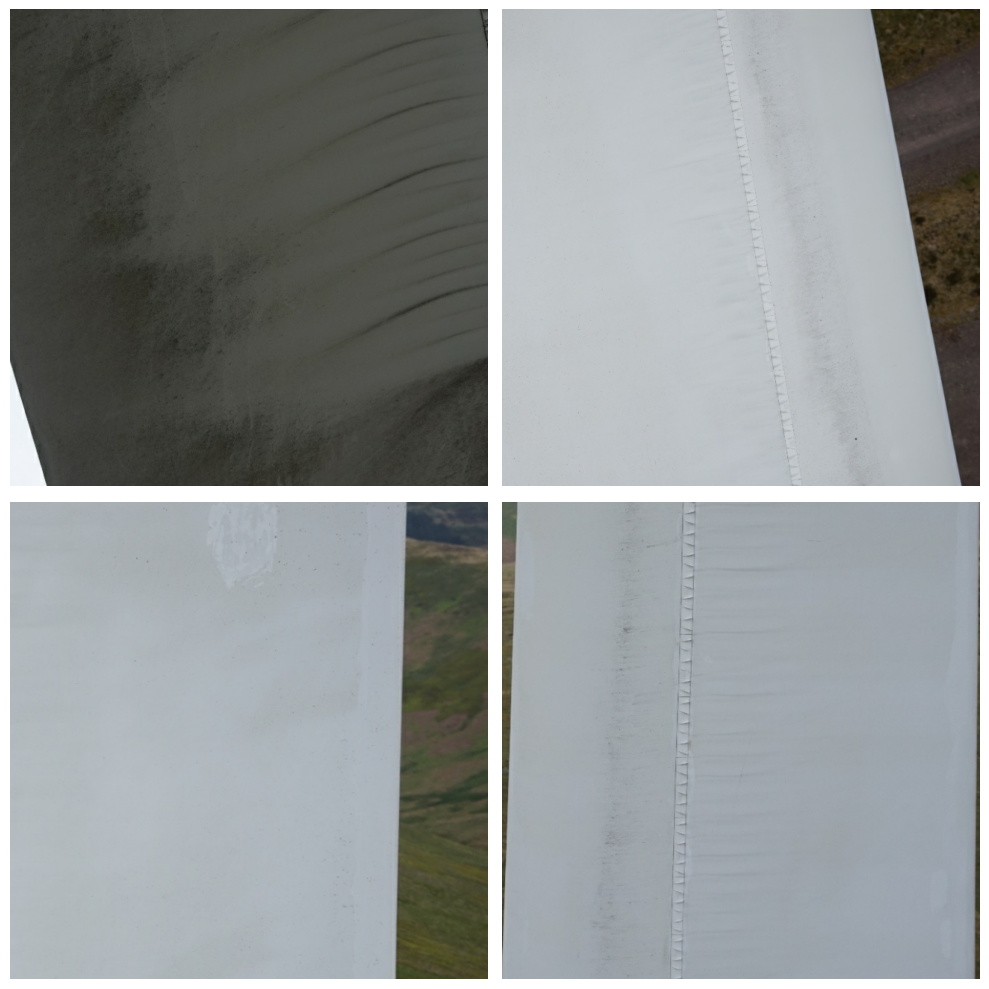

In [33]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    print(bounding_boxes)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=2, cols=2
)